# 消費者分群
## 使用 [電商零售資料集](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data)
這個計畫目的在於替消費者分群，利用主要購買的商品種類區分消費者族群，找出消費行為之間的相同與不同之處，以利廠商擬定行銷策略。  
其中會使用到的工具:  
+ 主成分分析 (Principle Component Analysis)  
+ K平均演算法 (K-means clustering)  
+ 先驗演算法 (Apriori  Algorithm)  

In [1]:
# 載入套件
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
aisles = pd.read_csv('D:/JupyterWorkspace/project/data/aisles.csv')
order_products_train = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__train.csv')
order_products_prior = pd.read_csv('D:/JupyterWorkspace/project/data/order_products__prior.csv')
orders = pd.read_csv('D:/JupyterWorkspace/project/data/orders.csv')
products = pd.read_csv('D:/JupyterWorkspace/project/data/products.csv')
departments = pd.read_csv('D:/JupyterWorkspace/project/data/departments.csv')

## 資料探索

In [3]:
# 商品種類
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
# 消費者最後一次消費所購買的項目
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [5]:
# 每位消費者先前的訂單所購買的商品
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
# 每位消費者的訂單紀錄
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
# 各項商品資料
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
# 商品所屬部門資料
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### 消費者消費次數的分布狀況

In [9]:
consumption_times = orders.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
consumption_times = consumption_times.order_number.value_counts()


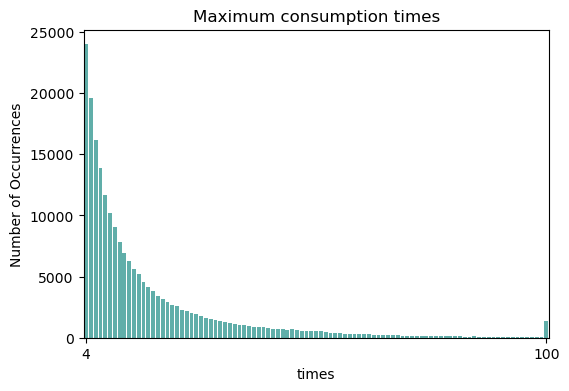

In [10]:
color='#28aaa2'
plt.figure(figsize=(6,4))
sns.barplot(x=consumption_times.index, y=consumption_times.values, alpha=0.8, color=color)
plt.title('Maximum consumption times')
plt.xlabel('times')
plt.ylabel('Number of Occurrences')
plt.xticks([0,96])
plt.show()

消費者消費次數分布從4次到100次，4次最多，呈現遞減趨勢

### 一周之中下單數分布狀況

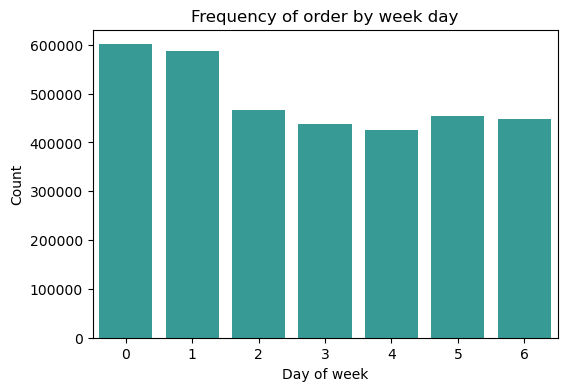

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x='order_dow', data=orders, color=color)
plt.title("Frequency of order by week day")
plt.xlabel('Day of week')
plt.ylabel('Count')
plt.show()

資料中沒有提到0到6分別代表星期幾，但我們推測下單數最多的兩天可能是週六和週日

### 一天之中下單數分布

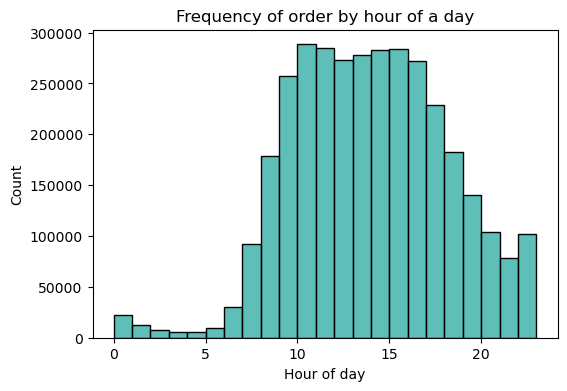

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(x='order_hour_of_day', data=orders, color=color, binwidth=1)
plt.title('Frequency of order by hour of a day')
plt.xlabel('Hour of day')
plt.ylabel('Count')
plt.show()

每天的下單時間集中白天，10到16點之間

In [13]:
# 製作新的data frame，內容包含幾乎所有訊息
# 因資料集龐大，隨機抽取60%的資料來進行後續分析
order_products_prior=order_products_prior.sample(frac=0.6,random_state=2023)
merged_df=pd.merge(order_products_prior, products, on=['product_id','product_id'])
merged_df=pd.merge(merged_df, orders, on=['order_id','order_id'])
merged_df=pd.merge(merged_df, aisles, on=['aisle_id','aisle_id'])
merged_df.head(5)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2713314,24799,2,1,Vanilla Skyr Nonfat Yogurt,120,16,202484,prior,29,0,11,8.0,yogurt
1,2713314,12745,1,1,"Yogurt, Lowfat, Strawberry",120,16,202484,prior,29,0,11,8.0,yogurt
2,2713314,39160,5,1,Kefir Cultured Strawberry Milk Drink,120,16,202484,prior,29,0,11,8.0,yogurt
3,2124951,24799,6,1,Vanilla Skyr Nonfat Yogurt,120,16,26825,prior,6,5,9,30.0,yogurt
4,2124951,13263,2,1,Non Fat Acai & Mixed Berries Yogurt,120,16,26825,prior,6,5,9,30.0,yogurt


In [14]:
merged_df.shape

(19460693, 14)

### 最熱銷的前20個商品種類

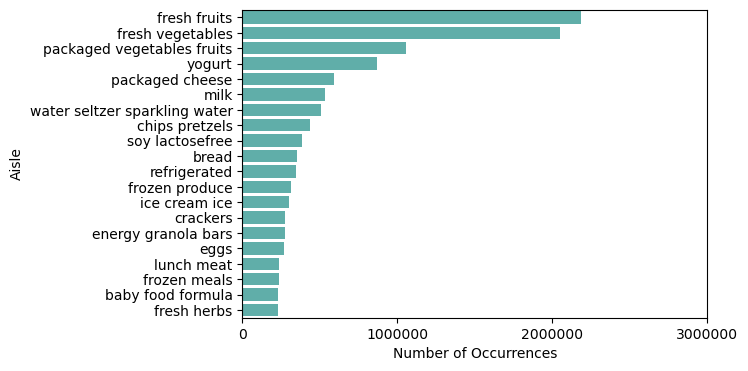

In [15]:
aisle_freq = merged_df.aisle.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=aisle_freq.index, x=aisle_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Aisle')
plt.xticks(np.arange(0,4000000,1000000),list(map(str,np.arange(0,4000000,1000000))))
plt.show()

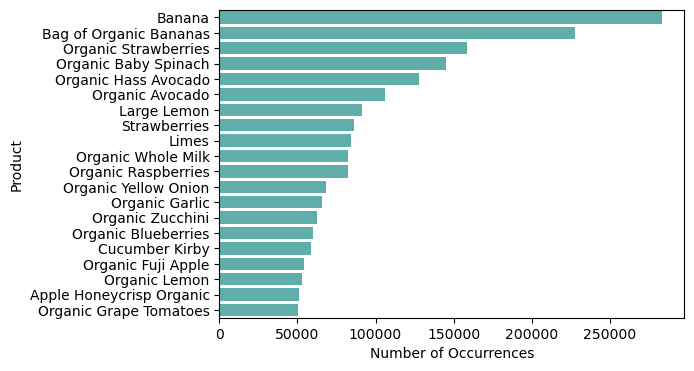

In [16]:
product_freq = merged_df.product_name.value_counts().head(20)
plt.figure(figsize=(6,4))
sns.barplot(y=product_freq.index, x=product_freq.values, alpha=0.8, color=color)
plt.xlabel('Number of Occurrences')
plt.ylabel('Product')
plt.show()

## 消費者分群

In [17]:
user_aisle_ct = pd.crosstab(merged_df.user_id, merged_df.aisle)
user_aisle_ct

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,0,0,0,0,...,2,1,1,0,0,0,0,2,0,24
3,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
206206,0,3,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
206207,0,0,0,0,0,0,0,0,0,0,...,2,4,0,1,0,0,0,7,0,12


先做主成分分析(PCA)把特徵濃縮到6個

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(user_aisle_ct)
pca_table=pd.DataFrame(pca.transform(user_aisle_ct))
pca_table

,0,1,2,3,4,5
0,-13.076356,2.210122,-2.456730,0.996259,0.184454,-0.662203
1,4.735628,21.524475,2.825625,10.278953,-4.516618,0.926149
2,-3.913079,1.238315,-7.269973,1.166479,-1.142467,-0.485058
3,-16.206596,-0.117497,-1.656095,1.101673,-0.311879,0.760961
4,-11.447604,-3.614298,0.846725,1.996236,0.288913,-0.313123
...,...,...,...,...,...,...
206145,-14.896665,-0.620920,0.926374,2.402010,0.144141,0.207837
206146,-5.514802,-0.065027,3.468304,-11.629067,0.762441,-6.632996
206147,3.016651,7.025401,8.060720,-2.389338,0.694903,-1.208907
206148,52.425129,9.060750,8.643744,-7.150086,6.212232,-20.288727


In [19]:
# 六個主成分分別解釋了多少變異
pca.explained_variance_ratio_

array([0.47267057, 0.09519144, 0.05244959, 0.0357636 , 0.02899945,
       0.02400682])

Text(0, 0.5, 'cumulated explained variance')

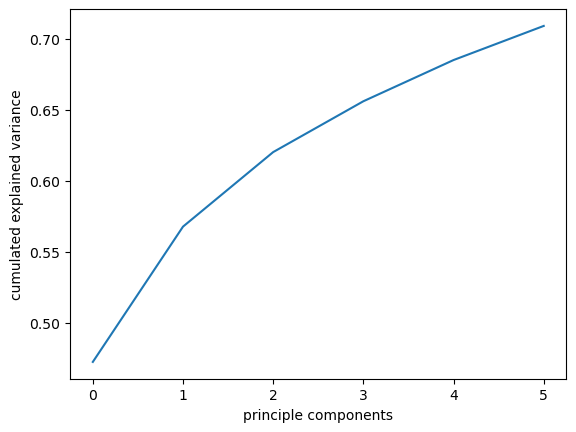

In [20]:
# 主成分解釋的變異累積圖
c_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(c_explained_variance_ratio)
plt.xlabel('principle components')
plt.ylabel('cumulated explained variance')

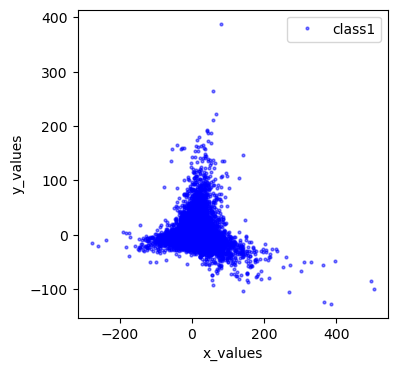

In [21]:
tocluster = pd.DataFrame(pca_table[[1,4]])

fig = plt.figure(figsize=(4,4))
plt.plot(tocluster[1], tocluster[4], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

### 利用elbow-method找出可能的分群數

Text(0.5, 1.0, 'KMeans elbow w/t Age')

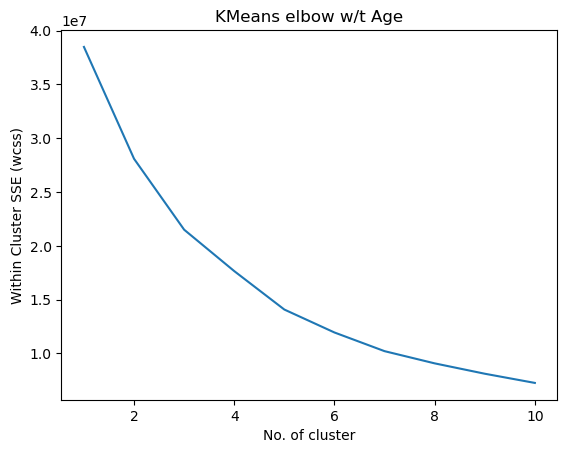

In [22]:
wcss = [] #within-cluster sum of squares
from sklearn.cluster import KMeans
for i in range(1,11): #跑10輪
    model = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 2023)
    model.fit(tocluster)
    wcss.append(model.inertia_)
    
fig,ax = plt.subplots()
sns.lineplot(x = list(range(1,11)), y = wcss, ax = ax)
ax.set_xlabel('No. of cluster')
ax.set_ylabel('Within Cluster SSE (wcss)')
ax.set_title('KMeans elbow w/t Age')

依照elbow-method的結果可看出，可能的群數是3或5，但經過實驗後，我認為分成5群有較好的結果

In [62]:
#用KMeans將消費者分成5群並找出群中點
kmeans = KMeans(n_clusters=5,random_state=2023).fit(tocluster)
centers = kmeans.cluster_centers_
c_preds = kmeans.predict(tocluster)
print(centers)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[-8.34371988e-01 -8.84179315e-03]
 [ 8.52234414e+01 -1.95720463e+01]
 [ 1.63768975e+01  4.81156072e+01]
 [ 1.83415984e+01 -1.83702166e+00]
 [-2.65438055e+01 -3.07344570e+00]]


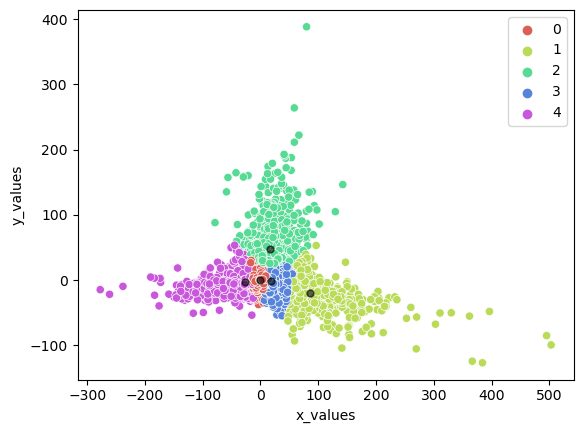

In [63]:
fig = plt.figure()
sns.scatterplot(
    x=tocluster[1],
    y=tocluster[4],
    hue=c_preds,
    palette = sns.color_palette('hls', 5)
)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=5, color='black', alpha=0.6)

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

試著找出新的觀點與模式

In [64]:
clustering_of_5_ct=user_aisle_ct.copy()
clustering_of_5_ct['cluster']=c_preds
clustering_of_5_ct.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,2,0,24,3
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


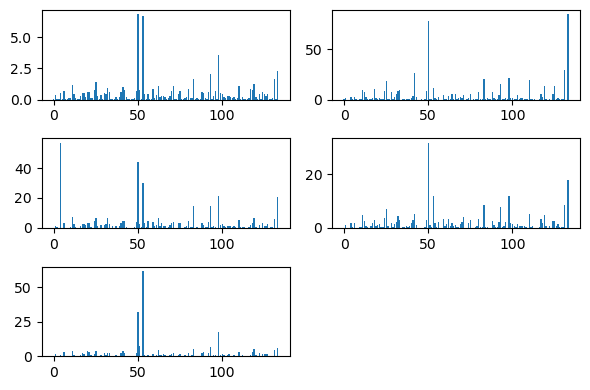

In [65]:
fig,axs = plt.subplots(3,2,figsize=(6,4))
feats=len(clustering_of_5_ct.drop('cluster',axis=1).columns)
c0 = clustering_of_5_ct[clustering_of_5_ct.cluster==0].drop('cluster',axis=1).mean()
axs[0,0].bar(range(feats),c0)
c1 = clustering_of_5_ct[clustering_of_5_ct.cluster==1].drop('cluster',axis=1).mean()
axs[0,1].bar(range(feats),c1)
c2 = clustering_of_5_ct[clustering_of_5_ct.cluster==2].drop('cluster',axis=1).mean()
axs[1,0].bar(range(feats),c2)
c3 = clustering_of_5_ct[clustering_of_5_ct.cluster==3].drop('cluster',axis=1).mean()
axs[1, 1].bar(range(feats),c3)
c4 = clustering_of_5_ct[clustering_of_5_ct.cluster==4].drop('cluster',axis=1).mean()
axs[2, 0].bar(range(feats),c4)
plt.delaxes()
plt.tight_layout()
plt.show()

In [56]:
c0.sort_values(ascending=False)[:10]

aisle
fresh fruits                     6.831599
fresh vegetables                 6.731501
packaged vegetables fruits       3.596438
yogurt                           2.272374
packaged cheese                  2.010198
milk                             1.685892
water seltzer sparkling water    1.622601
chips pretzels                   1.438714
soy lactosefree                  1.267373
bread                            1.205405
dtype: float64

In [57]:
c1.sort_values(ascending=False)[:10]

aisle
yogurt                           85.063330
fresh fruits                     78.798774
water seltzer sparkling water    29.993871
energy granola bars              26.617978
packaged vegetables fruits       21.362615
milk                             20.526047
refrigerated                     19.504597
chips pretzels                   19.009193
packaged cheese                  16.044944
tea                              14.029622
dtype: float64

In [58]:
c2.sort_values(ascending=False)[:10]

aisle
baby food formula             56.964734
fresh fruits                  43.717274
fresh vegetables              29.975493
packaged vegetables fruits    21.209803
yogurt                        20.420801
packaged cheese               14.696952
milk                          14.506276
bread                          7.424387
crackers                       6.893007
chips pretzels                 6.852959
dtype: float64

In [59]:
c3.sort_values(ascending=False)[:10]

aisle
fresh fruits                     31.681388
yogurt                           17.932641
packaged vegetables fruits       11.964063
fresh vegetables                 11.674398
milk                              8.613905
water seltzer sparkling water     8.370322
packaged cheese                   7.823901
chips pretzels                    6.968702
refrigerated                      5.305190
energy granola bars               5.292509
dtype: float64

In [60]:
c4.sort_values(ascending=False)[:10]

aisle
fresh vegetables                 61.993132
fresh fruits                     31.818042
packaged vegetables fruits       17.395695
fresh herbs                       7.184521
packaged cheese                   6.570989
yogurt                            6.153972
soy lactosefree                   5.556330
milk                              5.183598
frozen produce                    4.881394
water seltzer sparkling water     4.262737
dtype: float64

這裡我們可以看到第0,1,2群的消費者購買的商品種類，與先前得到的熱銷排行前10商品，大致相同，只有排名的順序稍有不同  
熱銷排名前10商品:  
+ fresh fruits  
+ fresh vegetables  
+ packaged vegetables fruits  
+ yogurt  
+ packaged cheese  
+ milk  
+ water seltzer sparkling water  
+ chips pretzels  
+ soy lactosefree  
+ bread   

另外可以觀察到第3群消費者比較特別，他們購買較多baby food formula，是熱銷排行前10以外的商品

## 關聯分析

Association Rules關聯規則三大指標:  
* Support: 支持度，某item-set在資料庫中出現的頻率  
support(x->y) = p(x,y)，其中x->y表示一條規則  
用法: 設定最小支持度作為篩選條件  

* Confidence: 信賴度，兩項目集之間的條件機率    
越高表示該關聯性規則具有高度關係  
用法: 設定最小信賴度作為篩選條件  

* Lift: 提升度，依賴度與y項目發生機率的比  

In [31]:
# 把內容最齊全的data frame(merged_df)加上消費者分群結果
user_cluster_ct=clustering_of_4_ct.drop(columns=clustering_of_4_ct.columns[:-1],inplace=False)
merged_df=pd.merge(user_cluster_ct,merged_df,on=['user_id','user_id'])
merged_df.shape

(19460693, 15)

In [32]:
# 用分群結果切割這個data frame
c0_merged_df=merged_df[merged_df.cluster==0]
c1_merged_df=merged_df[merged_df.cluster==1]
c2_merged_df=merged_df[merged_df.cluster==2]
c3_merged_df=merged_df[merged_df.cluster==3]

In [33]:
#製作新dataframe，將同群的消費者放在一起，內容只有order_id,product_name
c0_order_item = c0_merged_df[['order_id','product_name']]
c0_order_item.columns = ['order','item']
c0_order_item['temp'] = 1

c1_order_item = c1_merged_df[['order_id','product_name']]
c1_order_item.columns = ['order','item']
c1_order_item['temp'] = 1

c2_order_item = c2_merged_df[['order_id','product_name']]
c2_order_item.columns = ['order','item']
c2_order_item['temp'] = 1

c3_order_item = c3_merged_df[['order_id','product_name']]
c3_order_item.columns = ['order','item']
c3_order_item['temp'] = 1

C:\Users\jeff\AppData\Local\Temp\ipykernel_9460\4021627262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c0_order_item['temp'] = 1
C:\Users\jeff\AppData\Local\Temp\ipykernel_9460\4021627262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1_order_item['temp'] = 1
C:\Users\jeff\AppData\Local\Temp\ipykernel_9460\4021627262.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 